# Milestone Project 1: Food Vision 🍕

Annotated version of the notebook: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/07_food_vision_milestone_project_1.ipynb

In [1]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [2]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

## Get Helper Functions

The link to the script: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py

In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-01-26 10:19:59--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: 'helper_functions.py'

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-01-26 10:19:59 (42.3 MB/s) - 'helper_functions.py' saved [10246/10246]



In [4]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use TensorFlow Datasets to Download the Data

The overview of the TensorFlow Datasets: https://www.tensorflow.org/datasets/overview

In [5]:
import tensorflow_datasets as tfds

The Food-101 paper: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf

In [6]:
datasets_list = tfds.list_builders()

# Check for the Food101 dataset
'food101' in datasets_list

2024-01-26 10:20:01.009152: W external/local_tsl/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


True

In [7]:
(train_data, test_data), ds_info = tfds.load(
    name='food101',
    split=['train', 'validation'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

In [8]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

## Exploring the Food-101 Data

1. Class names
2. Shape of the input data
3. Data type of the input data
4. Type of labels (one-hot encoded or label encoded)
5. Do the labels match-up with the class names?

In [9]:
class_names = ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [10]:
train_one_sample = train_data.take(1)    # (image_tensor, label)

In [11]:
for image, label in train_one_sample:
    print(f'''
    Image shape: {image.shape}
    Image data type: {image.dtype}
    Target class (tensor): {label}
    Target class (string): {class_names[label.numpy()]}
    ''')


    Image shape: (512, 289, 3)
    Image data type: <dtype: 'uint8'>
    Target class (tensor): 45
    Target class (string): frozen_yogurt
    


In [12]:
image

<tf.Tensor: shape=(512, 289, 3), dtype=uint8, numpy=
array([[[145, 151, 125],
        [157, 163, 137],
        [159, 165, 139],
        ...,
        [197, 209, 199],
        [197, 209, 199],
        [197, 207, 198]],

       [[146, 152, 126],
        [156, 162, 136],
        [158, 164, 138],
        ...,
        [197, 209, 199],
        [197, 209, 199],
        [199, 209, 200]],

       [[150, 156, 130],
        [155, 161, 135],
        [157, 163, 137],
        ...,
        [197, 209, 199],
        [197, 209, 199],
        [199, 209, 198]],

       ...,

       [[173, 186, 177],
        [174, 187, 178],
        [176, 189, 180],
        ...,
        [181, 197, 187],
        [181, 197, 187],
        [178, 195, 187]],

       [[176, 187, 179],
        [176, 187, 179],
        [176, 189, 180],
        ...,
        [182, 198, 188],
        [182, 198, 188],
        [180, 197, 189]],

       [[178, 189, 181],
        [177, 188, 180],
        [175, 188, 179],
        ...,
        [179, 195, 18

In [13]:
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

## Plot an Image from the TensorFlow Dataset

In [14]:
import matplotlib.pyplot as plt

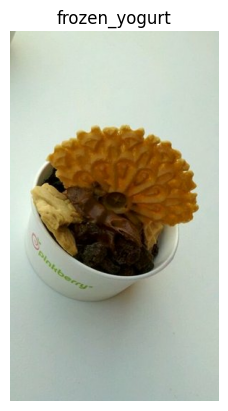

In [15]:
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

## Create Preprocessing Functions for the Data

What we know about the data:

* Data as `uint8` data type.
* Comprised of tensors of different sizes.
* Not scaled or standardised [0:255] -> [0:1].

What we know the models like:

* Data as `float32` dtype (or `float16` and `float32` for mixed precision).
* For batches, TensorFlow likes the tensors to be of the same size.
* Scaled or normalised tensors perform better.

In [16]:
def preprocess_img(image, label, img_shape=224):
    """Converts image data type to `float32` and reshapes
    image to (img_shape, img_shape, color_channels).
    """
    image = tf.image.resize(image, size=(img_shape, img_shape))
    return tf.cast(image, dtype=tf.float32), label

In [17]:
preprocessed_img = preprocess_img(image, label)[0]
print(f'''
Image before preprocessing:\n{image[:2]}
Shape: {image.shape}
Dtype: {image.dtype}
    
Image after preprocessing:\n{preprocessed_img[:2]}
Shape: {preprocessed_img.shape}
Dtype: {preprocessed_img.dtype}
''')


Image before preprocessing:
[[[145 151 125]
  [157 163 137]
  [159 165 139]
  ...
  [197 209 199]
  [197 209 199]
  [197 207 198]]

 [[146 152 126]
  [156 162 136]
  [158 164 138]
  ...
  [197 209 199]
  [197 209 199]
  [199 209 200]]]
Shape: (512, 289, 3)
Dtype: <dtype: 'uint8'>
    
Image after preprocessing:
[[[147.19739 153.19739 127.19739]
  [157.22768 163.22768 137.22768]
  [158.09805 164.09805 138.09805]
  ...
  [197.      209.      197.54907]
  [197.      209.      199.     ]
  [198.09914 208.38936 199.24425]]

 [[154.69467 160.69467 134.69467]
  [155.87053 161.87053 135.87053]
  [158.39908 164.39908 138.39908]
  ...
  [197.      209.      197.54907]
  [197.      209.      199.     ]
  [196.32831 206.61853 195.76364]]]
Shape: (224, 224, 3)
Dtype: <dtype: 'float32'>



## Batch and Prepare Datasets

For more resources: https://www.tensorflow.org/guide/data_performance

In [18]:
# Map the preprocessing function to the training data (and parallelize)
train_data = train_data.map(
    map_func=preprocess_img,
    num_parallel_calls=tf.data.AUTOTUNE
)

# Shuffle the training data and turn it into batches and prefetch it
train_data = train_data.shuffle(
    buffer_size=1000
).batch(
    batch_size=BATCH_SIZE
).prefetch(
    buffer_size=tf.data.AUTOTUNE
)

# Map the preprocessing function to the test data (and parallelize)
# and turn it into batches and prefetch it
test_data = test_data.map(
    map_func=preprocess_img,
    num_parallel_calls=tf.data.AUTOTUNE
).batch(
    batch_size=BATCH_SIZE
).prefetch(
    buffer_size=tf.data.AUTOTUNE
)

In [19]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Create the Modelling Callbacks

* `TensorBoard` callback to log training results (for visualisation).
* `ModelCheckpoint` callback to save the model's progress after feature extraction.

In [20]:
# Create TensorBoard callback
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback
checkpoint_path = 'mp1_model_checkpoints/cp.ckpt'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    verbose=0
)

## Setup Mixed Precision Training

For more information: https://www.tensorflow.org/guide/mixed_precision

Mixed precision utilises a combination of `float16` and `float32` dtypes to speed up model performance.

In [21]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy('mixed_float16')    # slow on the Apple M1

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [22]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Build the Feature Extraction Model

In [23]:
INPUT_SHAPE =  IMAGE_SIZE + (3,)
INPUT_SHAPE

(224, 224, 3)

In [24]:
# Create the base model
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

# Create the functional model
inputs = layers.Input(shape=INPUT_SHAPE, name='input_layer')
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
x = layers.Dense(len(class_names), name='output_layer')(x)
outputs = layers.Activation('softmax', dtype=tf.float32, name='softmax_float32')(x)

model = tf.keras.Model(inputs, outputs, name='food_vision')

# Compile the model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.legacy.Adam(),    # for the Apple M1 chip
    metrics=['accuracy']
)

In [25]:
model.summary()

Model: "food_vision"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                    

## Checking the Layer Data Type Policies (To Check for Mixed Precision)

This will be slow on the Apple M1 chip.

In [26]:
import pandas as pd

layer_data = []
for layer in model.layers:
    layer_data.append([layer.name, layer.trainable, layer.dtype, layer.dtype_policy])

pd.DataFrame(layer_data, columns=['layer_name', 'is_trainable', 'layer_dtype', 'layer_dtype_policy'])

,layer_name,is_trainable,layer_dtype,layer_dtype_policy
0,input_layer,True,float32,"<Policy ""float32"">"
1,efficientnetv2-b0,False,float32,"<Policy ""mixed_float16"">"
2,global_average_pooling_layer,True,float32,"<Policy ""mixed_float16"">"
3,output_layer,True,float32,"<Policy ""mixed_float16"">"
4,softmax_float32,True,float32,"<Policy ""float32"">"


In [27]:
base_layer_data = []
for layer in model.layers[1].layers:
    base_layer_data.append([layer.name, layer.trainable, layer.dtype, layer.dtype_policy])

pd.DataFrame(base_layer_data, columns=['layer_name', 'is_trainable', 'layer_dtype', 'layer_dtype_policy']).head(20)

,layer_name,is_trainable,layer_dtype,layer_dtype_policy
0,input_1,False,float32,"<Policy ""float32"">"
1,rescaling,False,float32,"<Policy ""mixed_float16"">"
2,normalization,False,float32,"<Policy ""mixed_float16"">"
3,stem_conv,False,float32,"<Policy ""mixed_float16"">"
4,stem_bn,False,float32,"<Policy ""mixed_float16"">"
5,stem_activation,False,float32,"<Policy ""mixed_float16"">"
6,block1a_project_conv,False,float32,"<Policy ""mixed_float16"">"
7,block1a_project_bn,False,float32,"<Policy ""mixed_float16"">"
8,block1a_project_activation,False,float32,"<Policy ""mixed_float16"">"
9,block2a_expand_conv,False,float32,"<Policy ""mixed_float16"">"


## Fit the Feature Extraction Model

The steps to fine-tune a pre-trained model generally include:

1. Build a feature extraction model (train a couple layers and freeze the base layers).
2. Fine-tune some of the frozen layers (by unfreezing them).

In [28]:
# Fit the model
feature_extraction_history = model.fit(
    train_data,
    epochs=3,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=int(.15 * len(test_data)),
    callbacks=[
        create_tensorboard_callback(
            dir_name='logs',
            experiment_name='efficientnetv2-b0_feature_extraction_101_food_classes'
        ),
        checkpoint_callback
    ]
)

Saving TensorBoard log files to: logs/efficientnetv2-b0_feature_extraction_101_food_classes/20240126-102009
Epoch 1/3
2368/2368 [==============================] - 1431s 601ms/step - loss: 1.7444 - accuracy: 0.5766 - val_loss: 1.1455 - val_accuracy: 0.6992
Epoch 2/3
2368/2368 [==============================] - 1419s 599ms/step - loss: 1.2103 - accuracy: 0.6860 - val_loss: 1.0441 - val_accuracy: 0.7233
Epoch 3/3
2368/2368 [==============================] - 1535s 648ms/step - loss: 1.0637 - accuracy: 0.7227 - val_loss: 0.9907 - val_accuracy: 0.7365


In [31]:
# Evaluate the model
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 485s 614ms/step - loss: 0.9911 - accuracy: 0.7305


[0.9910997748374939, 0.7304554581642151]

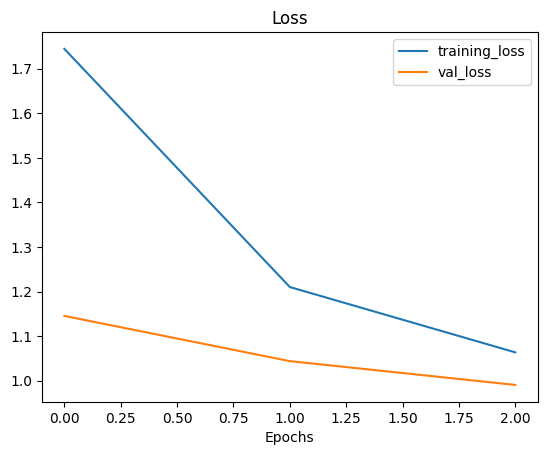

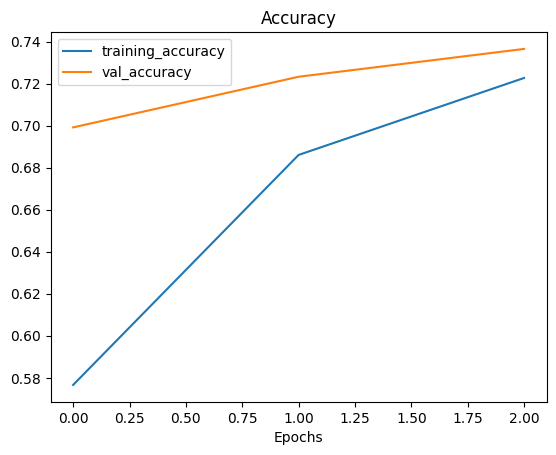

In [32]:
plot_loss_curves(feature_extraction_history)

## Fine-tune the Feature Extraction Model

Go through and fine-tune the model to improve the performance.

* Complete the [TEMPLATE](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/TEMPLATE_07_food_vision_milestone_project_1.ipynb) notebook.
* Refer to this [example](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/07_food_vision_milestone_project_1.ipynb) notebook.